In [57]:
using MAT, Statistics, LinearAlgebra,Random, Plots, NLsolve,StatsPlots
include("mvnrnd.jl")

mvnrnd (generic function with 1 method)

In [2]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    if size(v,2) == 1 # check if v is a column vector
        @eval (($s) = (vec($v)))
    else
        @eval (($s) = ($v))
    end
end

file = matopen("simulationData.mat")

#Reads in ju[IO, price, Omega, data, labor, mu, aggtfp, alpha, grossy, stfp, beta, agggdp, Sigma, capital, vadd]

varnames = names(file)
for varname in varnames
    val = read(file, varname)
    # Instantiate the variable with its name in the current scope
    string_as_varname(varname,val)
    end

close(file)

In [3]:
grossy = reshape(data[:,3],46,88)'
capital = reshape(data[:,4],46,88)'; #NOMINAL CAPITAL
labor = reshape(data[:,5],46,88)'; #NOMINAL LABOR
vadd = labor + capital; #NOMINAL VALUE;

In [4]:
removableSectors = [60, 80:88...];
grossy = grossy[setdiff(1:end,removableSectors),:];
capital = capital[setdiff(1:end,removableSectors),:];
labor = labor[setdiff(1:end,removableSectors),:];
vadd = vadd[setdiff(1:end,removableSectors),:];

In [5]:
grossSales = vec((sum(grossy,dims=2) .!= 0));
grossy = grossy[grossSales,:];
capital = capital[grossSales,:];
labor = labor[grossSales,:];
vadd2 = vadd[grossSales,:];

In [6]:
domar_weights = (inv(I - diagm(1 .- alpha) * Omega)' * beta);
L = domar_weights .* alpha;

In [7]:
ε = .5;
θ = 0.001;
σ = .9;

In [8]:
function problem(X, A, β, Ω, α, ε, θ, σ,L)
    N = length(α)
    p = X[1:N]
    y = X[N+1:end]
    
    Out = zeros(2*N)
    
    q = (Ω * p .^ (1-θ)) .^ (1 / (1 - θ))
    w = p .* (A .^ ((ε - 1)/ε)) .* (α .^ (1 / ε)) .* (y .^ (1/ε)) .* L .^ (-1/ε)
    C = w' * L

    Out[1:N] = p - (A .^ (ε - 1) .* (α .* w .^ (1- ε) + (1 .- α) .* q .^ (1 - ε))) .^ (1/(1-ε))
    Out[N+1:end] = y' - y' * diagm(p)^ε * diagm(A)^(ε-1) * diagm(q)^(θ-ε) * diagm(1 .- α) * Ω * diagm(p)^(-θ) - β'*diagm(p)^(-σ)*C
    
    return Out
end

problem (generic function with 1 method)

In [41]:
trials = 50;
GDP = zeros(trials)
A_logged = zeros(trials,76)
for k in 1:trials
    
        
    A = exp.(mvnrnd(-1/2*diag(Sigma),diagm(diag(Sigma))));
    x0 = [exp.(-inv(I - diagm(1 .- alpha)*Omega)*log.(A));domar_weights ./exp.(-inv(I - diagm(1 .- alpha) * Omega)*log.(A))];
    
    function f!(F,x)
        F[1:152] = problem(x, A, beta, Omega, alpha, ε, θ, σ,L)
    end

    x = nlsolve(f!,x0,iterations = 1000, xtol = 10^-16,ftol = 10^-14)
    if converged(x)
        GDP[k] = (x.zero[1:76] .* (A .^ ((ε-1)/ε)).*(alpha.^(1/ε)).*(x.zero[77:152].^(1/ε)).* L .^ (-1/ε))' * L;

    end
    
end

In [43]:
GDP

50-element Vector{Float64}:
 1.0010771686505562
 0.9974591289047829
 0.9954584805996457
 0.9890610069409929
 0.9871607940043057
 0.9999392595910281
 1.002236383143371
 1.0199797222201397
 0.9911608651875468
 1.0071031739297824
 0.9898941255076539
 0.9880163969944713
 1.0091320226726976
 ⋮
 1.0119854304822553
 0.9781584596611016
 0.9850018773481259
 0.9959305074618439
 0.9898198668389451
 0.9836596086246424
 1.000704527931969
 1.0031036812440697
 0.9994853212826618
 0.9902538852610658
 0.9987033289129366
 1.0062957019384329

In [25]:
A_logged

100×76 Matrix{Float64}:
 0.948058  1.05154   0.974438  0.892718  …  0.972392  1.02492   1.00867
 0.963627  0.994946  0.953408  1.01547      0.965733  0.995559  0.989127
 0.936672  0.98362   1.00874   0.911523     1.01734   1.04743   0.96196
 1.03047   0.951567  0.973846  0.999644     1.02003   1.01004   0.96739
 1.09371   1.05203   1.1026    1.05255      0.981352  0.948981  0.963741
 0.945173  1.03853   0.91023   1.05211   …  1.00566   0.98414   1.01718
 0.946709  0.959754  0.98145   0.952939     1.08006   0.981187  0.977664
 1.00561   1.04988   1.05539   0.952832     1.04755   0.998262  0.981862
 0.986421  0.997235  0.899116  0.880675     0.950388  0.994953  1.00431
 0.947669  0.987327  0.922945  1.02282      0.997689  1.00741   1.06281
 0.959964  1.00762   1.07333   0.95637   …  0.990442  0.975829  1.10546
 0.936606  1.03579   0.918404  1.04646      0.980706  0.952601  1.02832
 1.00033   0.963257  0.909097  0.975243     0.980693  0.964515  0.986201
 ⋮                                 

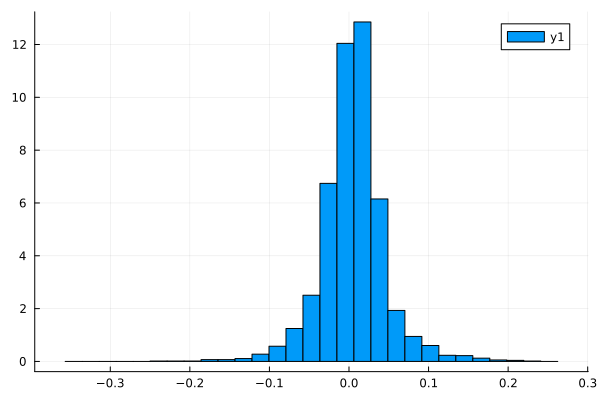

In [38]:
histogram(vec(stfp),normalize=:pdf,bins = range(log(0.7),log(1.3),30))

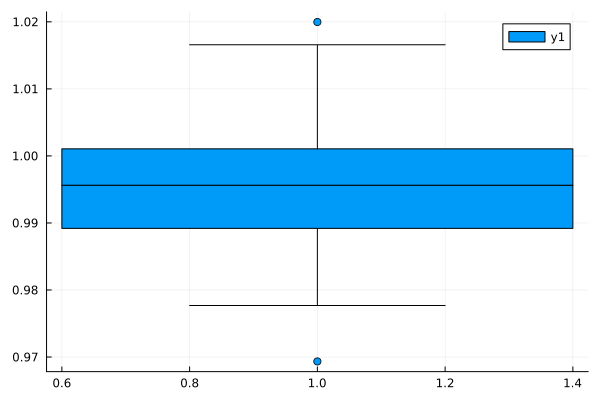